In [1139]:


from tensorflow import keras, config
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Set a global random state so that the nn gives the same results each time
keras.utils.set_random_seed(55)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
config.experimental.enable_op_determinism()

## Data analysis

In [1140]:
csv_path: str = "./BTCUSDT-D.csv"
price_data = pd.read_csv(csv_path)

## Features

In [1141]:
price_open = price_data.open
price_close = price_data.close
price_high = price_data.high
price_low = price_data.low

#### Create label targets

In [1142]:
target = []

for row in range(len(price_open)):
    
    if price_close[row] - price_open[row] > 0:
        target.append("long")
    else:
        target.append("short")

price_data["target"] = target

#### Add days and months from date col

In [1143]:
dates = price_data.date
day_list = []
month_list = []

for row in dates:
    day = row.split("-")[0]
    month = row.split("-")[2]

    day_list.append(day)
    month_list.append(month)

price_data["day"] = day_list
price_data["month"] = month_list

In [1144]:
price_data = price_data.drop(["date", "time", "volume"], axis=1)

#### Daily change (Feature)

In [1145]:
daily_change = [0]

for row in range(len(price_open)):

    if row == 0:
        continue

    change = (price_open[row] - price_open[row-1]) / price_open[row - 1] * 1000
    daily_change.append(round(change,8))

price_data["daily_change"] = daily_change

#### Volitility (Feature) *Currently not used

In [1146]:
volitility = [0]

for row in range(len(price_high)):

    if row == 0:
        continue

    vol = (price_high[row-1] - price_low[row-1]) /100
    volitility.append(vol)

price_data["volitility"] = volitility

price_data.head()

,open,high,low,close,target,day,month,daily_change,volitility
0,48610,51432,48030,50794,long,Thu,Dec,0.000000,0.00
1,50794,51980,50402,50785,short,Fri,Dec,44.929027,34.02
2,50785,51149,50100,50406,short,Sat,Dec,-0.177186,15.78
3,50406,51294,49283,50763,long,Sun,Dec,-7.462834,10.49
4,50763,52119,50464,50706,short,Mon,Dec,7.082490,20.11


## ML Workflow

#### Encoding

In [1147]:
# Ecode all text features to numbers for the nn to use

day_encoder = LabelEncoder()
month_encoder = LabelEncoder()
target_encoder = LabelEncoder()

day = day_encoder.fit_transform(price_data.day)
price_data["day"] = day

month = month_encoder.fit_transform(price_data.month)
price_data["month"] = month

target = target_encoder.fit_transform(price_data.target)
price_data["target"] = target

In [1148]:
# Select the features to be used in training the nn
X = price_data.filter(["day", "month", "daily_change", "target"])

# Split the training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X.drop("target", axis=1), X.target, random_state = 42)

# Split the alidation and training sets
X_val, X_train = X_train_full[:100], X_train_full[100:]
y_val, y_train = y_train_full[:100], y_train_full[100:]

# Get the number of features in the dataset by isolating the second number in "shape", this is needed to feed into the
# NN inputlayer
input_shape = X_train_full.shape[1]

#### NN model

In [1149]:
# Build the nn model



model = keras.models.Sequential([
              keras.layers.InputLayer(shape=(input_shape,)),         
              keras.layers.Dense(300, activation="relu"), 
              keras.layers.Dense(100, activation="relu"), 
              keras.layers.Dense(2, activation="softmax")
          ])

In [1150]:
# model.compile(loss="binary_crossentropy",
#              optimizer=keras.optimizers.SGD(learning_rate=0.001),
#              metrics=["accuracy"])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=0.00001),
             metrics=["accuracy"])


#### Training

In [1151]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5039 - loss: 1.1895 - val_accuracy: 0.5000 - val_loss: 0.9333
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.1596 - val_accuracy: 0.5000 - val_loss: 0.9146
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.1305 - val_accuracy: 0.5000 - val_loss: 0.8965
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.1023 - val_accuracy: 0.5000 - val_loss: 0.8792
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.0750 - val_accuracy: 0.5000 - val_loss: 0.8626
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.0486 - val_accuracy: 0.5000 - val_loss: 0.8467
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 1.0232 - val_accuracy: 0.5000 - val_loss: 0.8316
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 0.9987 - val_accuracy: 0.5000 - 

#### Visualization

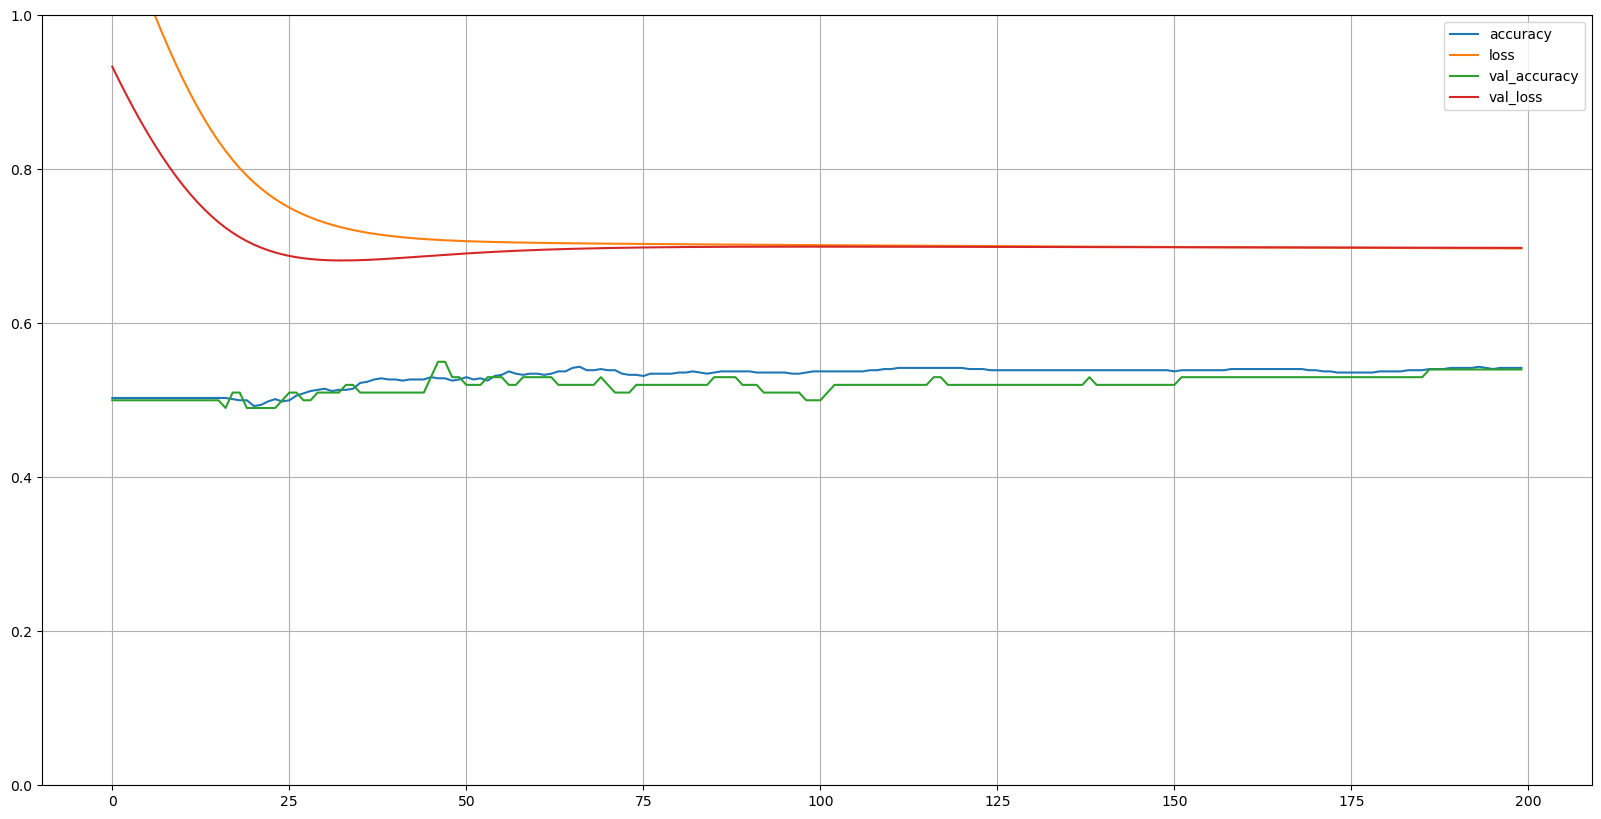

In [1152]:
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Results

#### Testing

In [1153]:
model.evaluate(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5264 - loss: 0.7133


[0.7279915809631348, 0.5]

In [1154]:
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


array([[0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.58, 0.42],
       [0.77, 0.23]], dtype=float32)

In [1155]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([0, 1, 1, 0, 0], dtype=int64)

In [1156]:
y_new = y_test[:5]
y_new

992    0
478    1
689    1
31     0
617    1
Name: target, dtype: int32